In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [4]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'histtype': 'stepfilled', 'alpha': 0.5, 'density': True}

In [5]:
# Check Versions
print(tf.__version__)  # 2.2.0
print(tf.keras.__version__)  # 2.3.0-tf

2.2.0
2.3.0-tf


# OmniFold Gaussian Toy Example

We will unfold the same data but with two cases:

(a) there are no generator MC weights from using simulation.

(b) there are generator MC weights from using simulation.

## Setup the Datasets

In [6]:
mu0 = 0
sigma0 = 1

In [7]:
N = 10**7
# param = (mu, sigma)
sim_param = (mu0, sigma0)  # synthetic sample
data_param = (1, 1.5)  # this is the data (the target)
epsilon = sigma0 / 1.  # Smearing width

sim_truth = np.random.normal(sim_param[0], sim_param[1],
                            N)  # Generator-level synthetic sample

# Toy MC weights from "MC sampling"
weight_MC_sim = np.array([(np.random.normal(abs(x), epsilon)) for x in sim_truth
                        ])  # Detector smearing for synthetic sample
sim_reco = np.array([(x + np.random.normal(0, epsilon)) for x in sim_truth
                     ])  # Detector smearing for synthetic sample
sim = np.stack([sim_truth, sim_reco], axis=1)
labels0 = np.zeros(len(sim))

data_truth = np.random.normal(data_param[0],
                                   data_param[1], N)
# Toy MC weights from "MC sampling"
weights_MC_data = np.array([(np.random.normal(abs(x), epsilon))
                              for x in data_truth])
# Detector smearing for synthetic sample
data_reco = np.array([(x + np.random.normal(0, epsilon))
                            for x in data_truth])
data = np.stack([data_truth, data_reco], axis=1)
labels_unknown = np.ones(len(data))

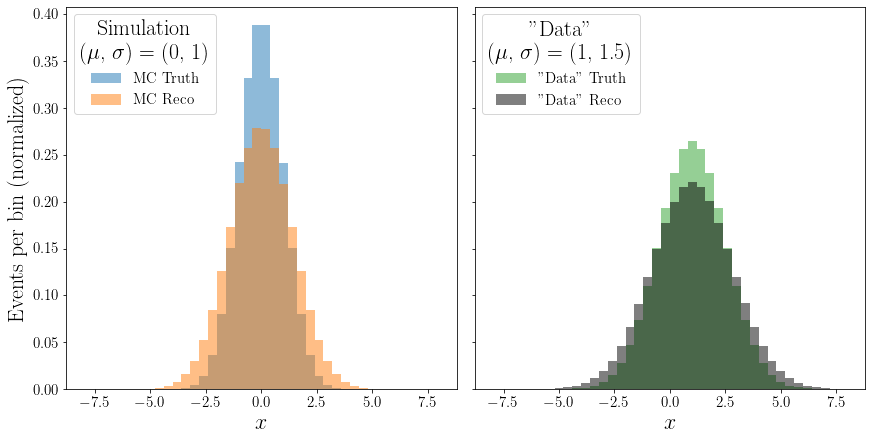

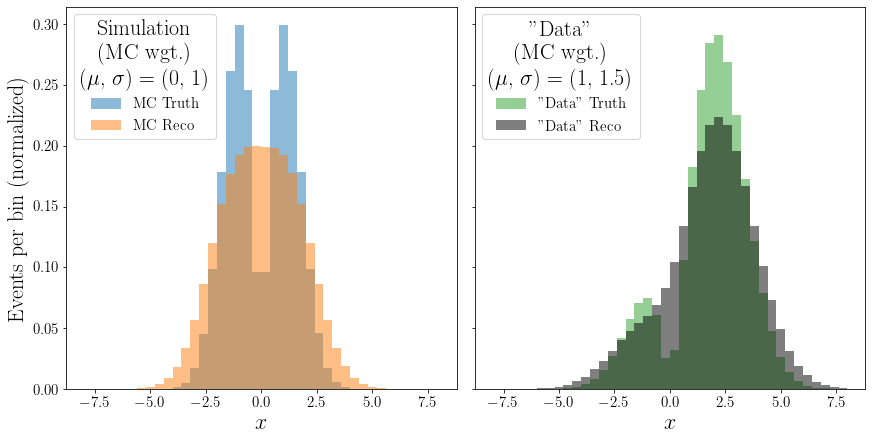

In [8]:
bins = np.linspace(-8, 8, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(sim_truth, bins=bins, **plot_style_2, label='MC Truth')
ax[0].hist(sim_reco, bins=bins, **plot_style_2, label='MC Reco')
legend = ax[0].legend(
    title='Simulation\n($\mu$, $\sigma$) = {}'.format(sim_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(data_truth,
           bins=bins,
           **plot_style_2,
           color='C2',
           label='"Data" Truth')
ax[1].hist(data_reco, bins=bins, **plot_style_2, color='k', label='"Data" Reco')
legend = ax[1].legend(
    title='"Data"\n($\mu$, $\sigma$) = {}'.format(data_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')
fig.savefig(
    'SupportNote/figures/GaussianToyExample/GaussianToyExample-Distributions.pdf',
    bbox_inches='tight')
fig.show()

bins = np.linspace(-8, 8, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(sim_truth,
           weights=weight_MC_sim,
           bins=bins,
           **plot_style_2,
           label='MC Truth')
ax[0].hist(sim_reco,
           weights=weight_MC_sim,
           bins=bins,
           **plot_style_2,
           label='MC Reco')
legend = ax[0].legend(
    title='Simulation \n(MC wgt.)\n($\mu$, $\sigma$) = {}'.format(sim_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(data_truth,
           weights=weights_MC_data,
           bins=bins,
           **plot_style_2,
           color='C2',
           label='"Data" Truth')
ax[1].hist(data_reco,
           weights=weights_MC_data,
           bins=bins,
           **plot_style_2,
           color='k',
           label='"Data" Reco')
legend = ax[1].legend(
    title='"Data" \n(MC wgt.)\n($\mu$, $\sigma$) = {}'.format(data_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')
fig.savefig(
    'SupportNote/figures/GaussianToyExample/GaussianToyExample-MCDistributions.pdf',
    bbox_inches='tight')
fig.show()

## Unfold Data

In [9]:
# Binary crossentropy for classifying two samples with weights
# Weights are "hidden" by zipping in y_true (the labels)

def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))
    
    return K.mean(t_loss)

In [10]:
iterations = 10
batch_size= 10000

In [11]:
xvals_1 = np.concatenate((sim_reco, data_reco))
yvals_1 = np.concatenate((labels0, labels_unknown))

xvals_2 = np.concatenate((sim_truth, sim_truth))
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(sim)))
# shape = (iteration, step, event)

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

In [12]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=1000)
    weights = f / (1. - f)
    return np.squeeze(weights)

### Unfold without initial MC weights

In [13]:
# initial iterative weights are ones

weights_pull = np.ones(len(sim_reco))
weights_push = np.ones(len(sim_reco))

In [14]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify MC Reco (which is reweighted by weights_push) to "Data" Reco
    # weights reweighted MC Reco --> "Data" Reco
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, np.ones(len(data_reco))))
    # actual weights for MC Reco, ones for "Data" Reco (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)
    
    # zip ("hide") the weights with the labels
    Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
    Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)
    
    
    model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_1, Y_test_1),
              callbacks=[earlystopping],
              verbose=1)

    weights_pull = weights_push * reweight(sim_reco)
    weights[i, :1, :] = weights_pull

    # STEP 2: classify MC Truth to reweighted MC Truth (which is reweighted by weights_pull)
    # weights MC Truth --> reweighted MC Truth
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((np.ones(len(sim_truth)), weights_pull))
    # ones for MC Truth (not MC weights), actual weights for (reweighted) MC Truth

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)
    
    # zip ("hide") the weights with the labels
    Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
    Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

    model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_2, Y_test_2),
              callbacks=[earlystopping],
              verbose=1)

    weights_push = reweight(sim_truth)
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Epoch 1/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6370 - accuracy: 0.5033 - val_loss: 0.6363 - val_accuracy: 0.5075
Epoch 2/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6364 - accuracy: 0.5033 - val_loss: 0.6364 - val_accuracy: 0.5001
Epoch 3/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6364 - accuracy: 0.5028 - val_loss: 0.6363 - val_accuracy: 0.5041
Epoch 4/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6364 - accuracy: 0.5024 - val_loss: 0.6363 - val_accuracy: 0.5044
Epoch 5/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6364 - accuracy: 0.5031 - val_loss: 0.6363 - val_accuracy: 0.5035
Epoch 6/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6364 - accuracy: 0.5034 - val_loss: 0.6363 - val_accuracy: 0.4994
Epoch 7/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6363 - accuracy: 0.5037 - va

1500/1500 [==============================] - 3s 2ms/step - loss: 0.6742 - accuracy: 0.4154 - val_loss: 0.6746 - val_accuracy: 0.4197
Epoch 17/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6742 - accuracy: 0.4157 - val_loss: 0.6745 - val_accuracy: 0.4122
Epoch 18/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6742 - accuracy: 0.4152 - val_loss: 0.6746 - val_accuracy: 0.4175
Epoch 19/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6742 - accuracy: 0.4152 - val_loss: 0.6746 - val_accuracy: 0.4190
Epoch 20/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6742 - accuracy: 0.4150 - val_loss: 0.6745 - val_accuracy: 0.4176
Epoch 21/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6742 - accuracy: 0.4149 - val_loss: 0.6745 - val_accuracy: 0.4173
Epoch 22/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6742 - accuracy: 0.4151 - val_loss: 0.6745 - val_accuracy

1500/1500 [==============================] - 4s 3ms/step - loss: 0.6089 - accuracy: 0.3032 - val_loss: 0.6089 - val_accuracy: 0.3028
Epoch 12/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6089 - accuracy: 0.3033 - val_loss: 0.6089 - val_accuracy: 0.3038
Epoch 13/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6089 - accuracy: 0.3034 - val_loss: 0.6089 - val_accuracy: 0.3037
Epoch 14/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6089 - accuracy: 0.3032 - val_loss: 0.6089 - val_accuracy: 0.3034
Epoch 15/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6089 - accuracy: 0.3033 - val_loss: 0.6091 - val_accuracy: 0.3055
Epoch 16/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6089 - accuracy: 0.3035 - val_loss: 0.6089 - val_accuracy: 0.3038
Epoch 00016: early stopping

ITERATION: 4

STEP 1

Epoch 1/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6976 - 

1500/1500 [==============================] - 3s 2ms/step - loss: 0.6960 - accuracy: 0.3204 - val_loss: 0.6944 - val_accuracy: 0.3514
Epoch 4/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6960 - accuracy: 0.3213 - val_loss: 0.6945 - val_accuracy: 0.3157
Epoch 5/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6960 - accuracy: 0.3217 - val_loss: 0.6944 - val_accuracy: 0.3249
Epoch 6/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6960 - accuracy: 0.3255 - val_loss: 0.6944 - val_accuracy: 0.3197
Epoch 7/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6959 - accuracy: 0.3163 - val_loss: 0.6944 - val_accuracy: 0.3500
Epoch 8/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6960 - accuracy: 0.3356 - val_loss: 0.6950 - val_accuracy: 0.3461
Epoch 9/200
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6961 - accuracy: 0.3348 - val_loss: 0.6950 - val_accuracy: 0.32

1500/1500 [==============================] - 3s 2ms/step - loss: 0.5963 - accuracy: 0.2982 - val_loss: 0.5964 - val_accuracy: 0.2992
Epoch 3/200
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5963 - accuracy: 0.2976 - val_loss: 0.5964 - val_accuracy: 0.2994
Epoch 4/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5963 - accuracy: 0.2977 - val_loss: 0.5963 - val_accuracy: 0.2974
Epoch 5/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5963 - accuracy: 0.2977 - val_loss: 0.5964 - val_accuracy: 0.2972
Epoch 6/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5963 - accuracy: 0.2979 - val_loss: 0.5964 - val_accuracy: 0.3000
Epoch 7/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5963 - accuracy: 0.2979 - val_loss: 0.5964 - val_accuracy: 0.3001
Epoch 8/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5963 - accuracy: 0.2978 - val_loss: 0.5964 - val_accuracy: 0.29

Epoch 7/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5959 - accuracy: 0.2978 - val_loss: 0.5957 - val_accuracy: 0.2959
Epoch 8/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5959 - accuracy: 0.2979 - val_loss: 0.5957 - val_accuracy: 0.2982
Epoch 9/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5959 - accuracy: 0.2979 - val_loss: 0.5957 - val_accuracy: 0.2985
Epoch 10/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5959 - accuracy: 0.2979 - val_loss: 0.5957 - val_accuracy: 0.2991
Epoch 11/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5959 - accuracy: 0.2979 - val_loss: 0.5957 - val_accuracy: 0.2980
Epoch 12/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5959 - accuracy: 0.2979 - val_loss: 0.5957 - val_accuracy: 0.2993
Epoch 13/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5959 - accuracy: 0.2979 - val_loss: 0.5957 - va

1500/1500 [==============================] - 3s 2ms/step - loss: 0.6951 - accuracy: 0.3437 - val_loss: 0.6944 - val_accuracy: 0.4736
Epoch 6/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6950 - accuracy: 0.3414 - val_loss: 0.6940 - val_accuracy: 0.2559
Epoch 7/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6951 - accuracy: 0.3336 - val_loss: 0.6939 - val_accuracy: 0.2986
Epoch 8/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6950 - accuracy: 0.3274 - val_loss: 0.6939 - val_accuracy: 0.3491
Epoch 9/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6949 - accuracy: 0.3223 - val_loss: 0.6940 - val_accuracy: 0.3505
Epoch 10/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6950 - accuracy: 0.3195 - val_loss: 0.6942 - val_accuracy: 0.4039
Epoch 11/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6949 - accuracy: 0.3177 - val_loss: 0.6941 - val_accuracy: 0.

Epoch 25/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6894 - accuracy: 0.4695 - val_loss: 0.6896 - val_accuracy: 0.5002
Epoch 26/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6893 - accuracy: 0.4651 - val_loss: 0.6907 - val_accuracy: 0.5002
Epoch 27/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6896 - accuracy: 0.4727 - val_loss: 0.6898 - val_accuracy: 0.5002
Epoch 00027: early stopping

STEP 2

Epoch 1/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6023 - accuracy: 0.3110 - val_loss: 0.5936 - val_accuracy: 0.2956
Epoch 2/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5937 - accuracy: 0.2965 - val_loss: 0.5937 - val_accuracy: 0.2970
Epoch 3/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5937 - accuracy: 0.2964 - val_loss: 0.5936 - val_accuracy: 0.2960
Epoch 4/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5937 - accu

#### Results

ITERATION 1:


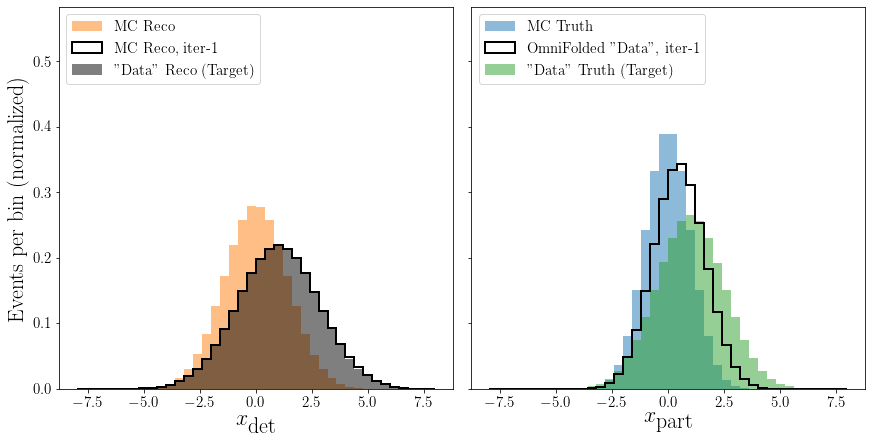

ITERATION 2:


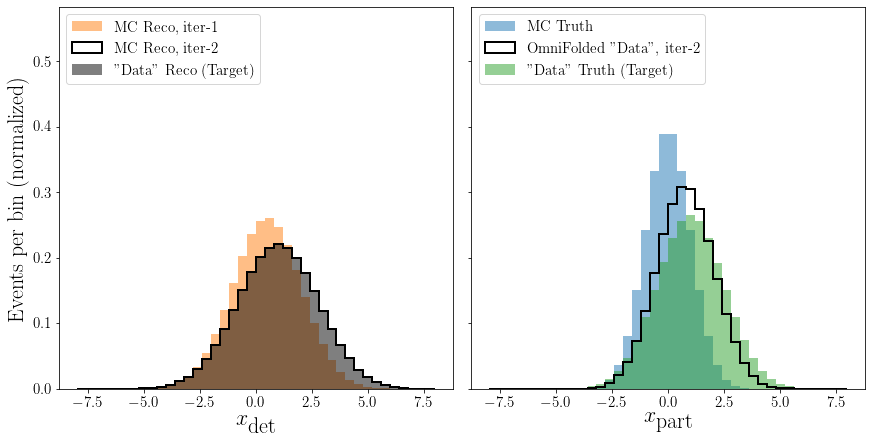

ITERATION 3:


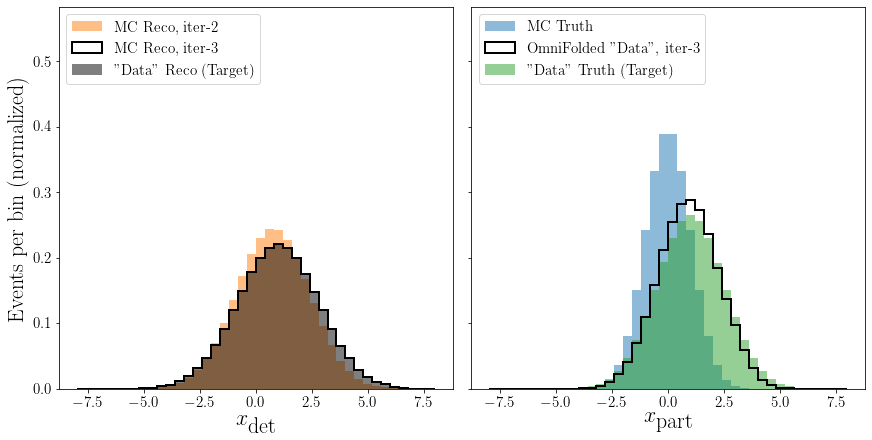

ITERATION 4:


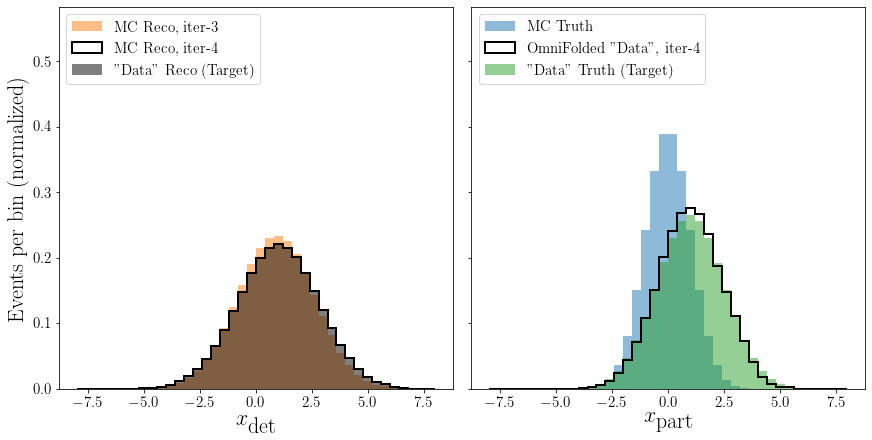

ITERATION 5:


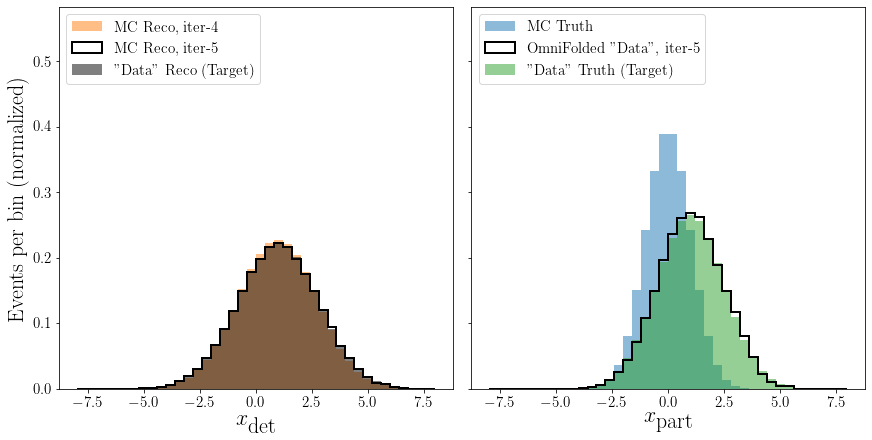

ITERATION 6:


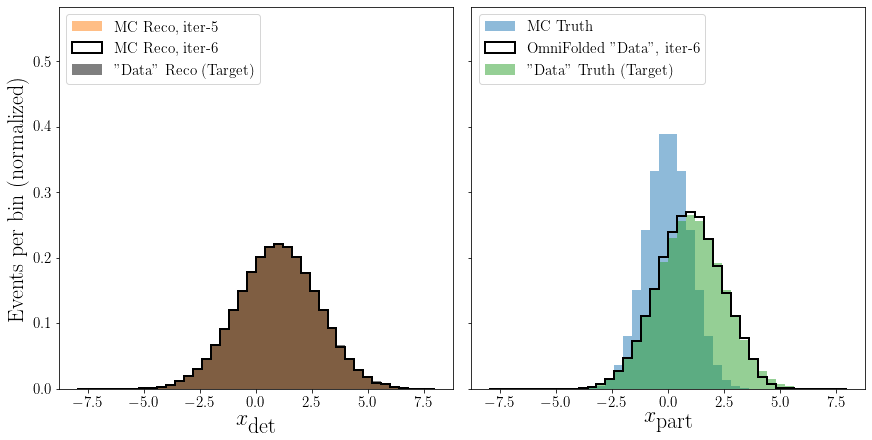

ITERATION 7:


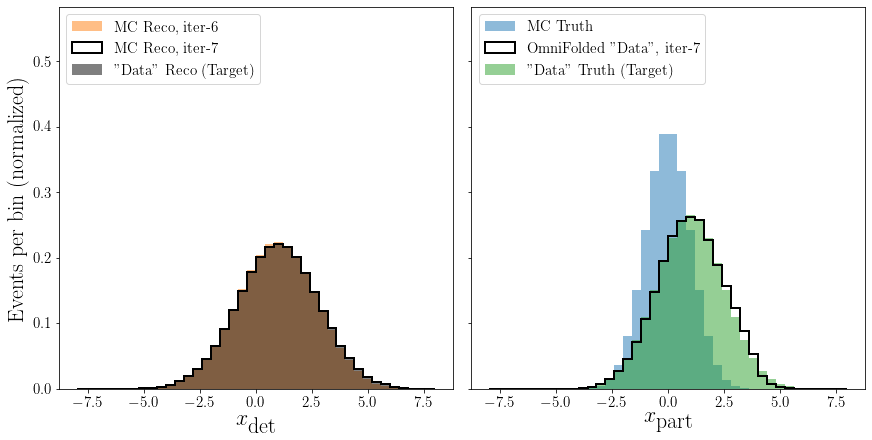

ITERATION 8:


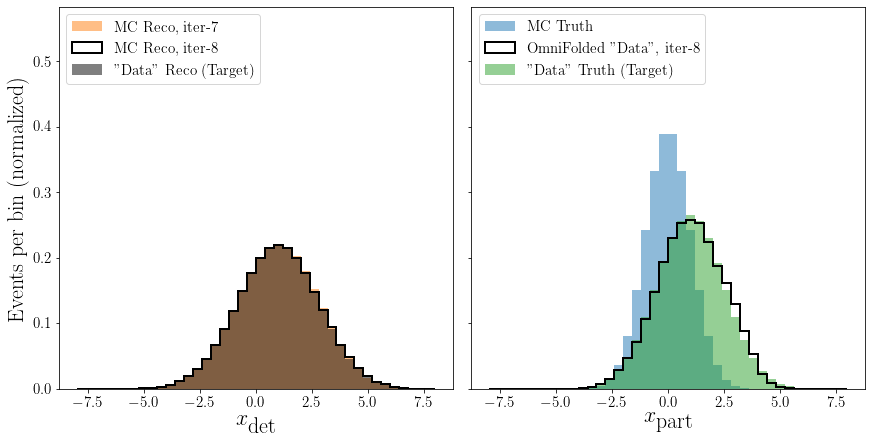

ITERATION 9:


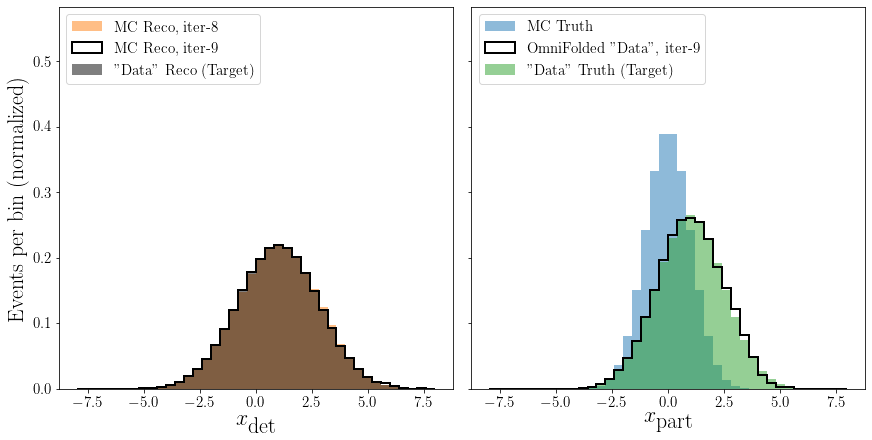

ITERATION 10:


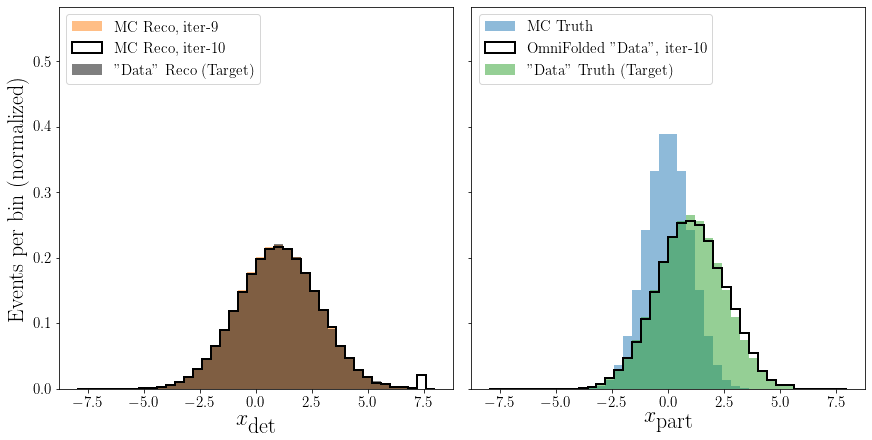

In [15]:
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = np.ones(len(sim_reco))
        label0 = ''.format(i)
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    hR0,_,_ = ax[0].hist(sim_reco,
               weights=weights_init,
               bins=bins,
               label='MC Reco' + label0,
               **plot_style_2,
               color='C1')

    hR1,_,_ = ax[0].hist(
        sim_reco,
        bins=bins,
        label='MC Reco'+label1,
        weights=weights[i, 0, :],
        **plot_style_1)
    hR2,_,_ = ax[0].hist(data_reco,
               bins=bins,
               label='"Data" Reco (Target)',
               **plot_style_2,
               color='k')
    ax[0].set_xlabel(r"$x_{\textrm{det}}$")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend(loc='upper left')
    hT0,_,_ = ax[1].hist(sim_truth, bins=bins, label=r'MC Truth', **plot_style_2)

    hT1,_,_ = ax[1].hist(
        sim_truth,
        bins=bins,
        label='OmniFolded "Data"'+label1,
        weights=weights[i, 1, :],
        **plot_style_1)
    hT2,_,_ = ax[1].hist(data_truth,
               bins=bins,
               label='"Data" Truth (Target)',
               **plot_style_2,
               color='C2')
    ax[1].legend(loc='upper left')
    ax[1].set_xlabel(r"$x_{\textrm{part}}$")
    
    ax[0].set_ylim([0,1.5*np.max(np.concatenate((hT0, hT1, hT2, hR0, hR1,hR2)))])
    
    fig.show()
    fig.savefig(
        'SupportNote/figures/GaussianToyExample/GaussianToyExample-UnfoldingResultsIteration{:02}.pdf'
        .format(i + 1),
        bbox_inches='tight')
    plt.show()

### Unfold with initial MC weights

In [16]:
# increase number of iterations
iterations = 10

In [17]:
# initial iterative weights are MC weights

weights_pull = weight_MC_sim
weights_push = weight_MC_sim

In [18]:
# clear total weights

weights = np.empty(shape=(iterations, 2, len(sim)))
# shape = (iteration, step, event)

In [19]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify MC Reco (which is reweighted by weights_push) to "Data" Reco
    # weights reweighted MC Reco --> "Data" Reco
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, weights_MC_data))
    # actual weights for MC Reco, initial MC weights for "Data" Reco

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)
    
    # zip ("hide") the weights with the labels
    Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
    Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)

    model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_1, Y_test_1),
              callbacks=[earlystopping],
              verbose=1)

    weights_pull = weights_push * reweight(sim_reco)
    weights[i, :1, :] = weights_pull

    # STEP 2: classify MC Truth to reweighted MC Truth (which is reweighted by weights_pull)
    # weights MC Truth --> reweighted MC Truth
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((weight_MC_sim, weights_pull))
    # initial MC weights for MC Truth, actual weights for (reweighted) MC Truth

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)
    
    # zip ("hide") the weights with the labels
    Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
    Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

    model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_2, Y_test_2),
              callbacks=[earlystopping],
              verbose=1)

    # note we need to take into account MC weights when reweighting the synthetic MC Truth
    weights_push = weight_MC_sim * reweight(sim_truth)
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Epoch 1/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6171 - accuracy: 0.3088 - val_loss: 0.6173 - val_accuracy: 0.3089
Epoch 2/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6166 - accuracy: 0.3084 - val_loss: 0.6172 - val_accuracy: 0.3078
Epoch 3/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6166 - accuracy: 0.3085 - val_loss: 0.6172 - val_accuracy: 0.3086
Epoch 4/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6166 - accuracy: 0.3085 - val_loss: 0.6173 - val_accuracy: 0.3078
Epoch 5/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6166 - accuracy: 0.3085 - val_loss: 0.6172 - val_accuracy: 0.3085
Epoch 6/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6166 - accuracy: 0.3085 - val_loss: 0.6172 - val_accuracy: 0.3079
Epoch 7/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6166 - accuracy: 0.3086 - va

1500/1500 [==============================] - 4s 3ms/step - loss: 0.9625 - accuracy: 0.2976 - val_loss: 0.9609 - val_accuracy: 0.2972
Epoch 9/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.9625 - accuracy: 0.2975 - val_loss: 0.9613 - val_accuracy: 0.2953
Epoch 10/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.9625 - accuracy: 0.2975 - val_loss: 0.9612 - val_accuracy: 0.2996
Epoch 11/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.9624 - accuracy: 0.2976 - val_loss: 0.9611 - val_accuracy: 0.2958
Epoch 12/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.9625 - accuracy: 0.2976 - val_loss: 0.9610 - val_accuracy: 0.2963
Epoch 13/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.9625 - accuracy: 0.2976 - val_loss: 0.9610 - val_accuracy: 0.2986
Epoch 14/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.9624 - accuracy: 0.2978 - val_loss: 0.9613 - val_accuracy:

Epoch 29/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.9982 - accuracy: 0.2834 - val_loss: 0.9942 - val_accuracy: 0.2822
Epoch 00029: early stopping

STEP 2

Epoch 1/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5837 - accuracy: 0.2499 - val_loss: 0.5769 - val_accuracy: 0.2503
Epoch 2/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5774 - accuracy: 0.2499 - val_loss: 0.5769 - val_accuracy: 0.2503
Epoch 3/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5774 - accuracy: 0.2499 - val_loss: 0.5769 - val_accuracy: 0.2503
Epoch 4/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5774 - accuracy: 0.2499 - val_loss: 0.5769 - val_accuracy: 0.2503
Epoch 5/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5774 - accuracy: 0.2499 - val_loss: 0.5769 - val_accuracy: 0.2503
Epoch 6/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5774 - accura

1500/1500 [==============================] - 4s 3ms/step - loss: 0.5622 - accuracy: 0.2500 - val_loss: 0.5634 - val_accuracy: 0.2500
Epoch 8/200
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5622 - accuracy: 0.2500 - val_loss: 0.5631 - val_accuracy: 0.2500
Epoch 9/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5622 - accuracy: 0.2500 - val_loss: 0.5629 - val_accuracy: 0.2499
Epoch 10/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5622 - accuracy: 0.2500 - val_loss: 0.5630 - val_accuracy: 0.2499
Epoch 11/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5622 - accuracy: 0.2500 - val_loss: 0.5632 - val_accuracy: 0.2499
Epoch 12/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5622 - accuracy: 0.2500 - val_loss: 0.5630 - val_accuracy: 0.2499
Epoch 13/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5622 - accuracy: 0.2500 - val_loss: 0.5629 - val_accuracy: 

1500/1500 [==============================] - 4s 3ms/step - loss: 1.0326 - accuracy: 0.2507 - val_loss: 1.0441 - val_accuracy: 0.2510
Epoch 7/200
1500/1500 [==============================] - 4s 3ms/step - loss: 1.0323 - accuracy: 0.2453 - val_loss: 1.0463 - val_accuracy: 0.2396
Epoch 8/200
1500/1500 [==============================] - 4s 3ms/step - loss: 1.0326 - accuracy: 0.2520 - val_loss: 1.0600 - val_accuracy: 0.2320
Epoch 9/200
1500/1500 [==============================] - 4s 3ms/step - loss: 1.0323 - accuracy: 0.2470 - val_loss: 1.0442 - val_accuracy: 0.2504
Epoch 10/200
1500/1500 [==============================] - 4s 3ms/step - loss: 1.0323 - accuracy: 0.2490 - val_loss: 1.0434 - val_accuracy: 0.2502
Epoch 11/200
1500/1500 [==============================] - 4s 3ms/step - loss: 1.0336 - accuracy: 0.2488 - val_loss: 1.0438 - val_accuracy: 0.2489
Epoch 12/200
1500/1500 [==============================] - 4s 3ms/step - loss: 1.0322 - accuracy: 0.2519 - val_loss: 1.0458 - val_accuracy: 0

1500/1500 [==============================] - 4s 3ms/step - loss: 0.5530 - accuracy: 0.2500 - val_loss: 0.5532 - val_accuracy: 0.2500
Epoch 24/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5530 - accuracy: 0.2500 - val_loss: 0.5532 - val_accuracy: 0.2500
Epoch 25/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5530 - accuracy: 0.2500 - val_loss: 0.5533 - val_accuracy: 0.2500
Epoch 26/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5530 - accuracy: 0.2500 - val_loss: 0.5532 - val_accuracy: 0.2500
Epoch 27/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5530 - accuracy: 0.2500 - val_loss: 0.5532 - val_accuracy: 0.2500
Epoch 28/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5530 - accuracy: 0.2500 - val_loss: 0.5532 - val_accuracy: 0.2500
Epoch 00028: early stopping

ITERATION: 7

STEP 1

Epoch 1/200
1500/1500 [==============================] - 4s 3ms/step - loss: 1.0060 - 

1500/1500 [==============================] - 4s 3ms/step - loss: 1.0333 - accuracy: 0.2225 - val_loss: 1.0292 - val_accuracy: 0.2483
Epoch 00017: early stopping

STEP 2

Epoch 1/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5735 - accuracy: 0.2500 - val_loss: 0.5609 - val_accuracy: 0.2501
Epoch 2/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5607 - accuracy: 0.2500 - val_loss: 0.5607 - val_accuracy: 0.2501
Epoch 3/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5607 - accuracy: 0.2500 - val_loss: 0.5606 - val_accuracy: 0.2501
Epoch 4/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5607 - accuracy: 0.2500 - val_loss: 0.5607 - val_accuracy: 0.2501
Epoch 5/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5606 - accuracy: 0.2500 - val_loss: 0.5606 - val_accuracy: 0.2501
Epoch 6/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5606 - accuracy: 0.2500 - 

Epoch 34/200
1500/1500 [==============================] - 4s 3ms/step - loss: 1.0147 - accuracy: 0.2269 - val_loss: 1.0095 - val_accuracy: 0.2074
Epoch 35/200
1500/1500 [==============================] - 4s 3ms/step - loss: 1.0149 - accuracy: 0.2161 - val_loss: 1.0105 - val_accuracy: 0.2134
Epoch 36/200
1500/1500 [==============================] - 4s 3ms/step - loss: 1.0154 - accuracy: 0.2164 - val_loss: 1.0102 - val_accuracy: 0.2152
Epoch 37/200
1500/1500 [==============================] - 4s 3ms/step - loss: 1.0158 - accuracy: 0.2216 - val_loss: 1.0136 - val_accuracy: 0.2302
Epoch 00037: early stopping

STEP 2

Epoch 1/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5690 - accuracy: 0.2500 - val_loss: 0.5603 - val_accuracy: 0.2502
Epoch 2/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5577 - accuracy: 0.2500 - val_loss: 0.5600 - val_accuracy: 0.2501
Epoch 3/200
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5577 - acc

Epoch 23/200
1500/1500 [==============================] - 3s 2ms/step - loss: 1.0392 - accuracy: 0.2460 - val_loss: 1.0355 - val_accuracy: 0.2501
Epoch 00023: early stopping

STEP 2

Epoch 1/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5850 - accuracy: 0.2500 - val_loss: 0.5628 - val_accuracy: 0.2500
Epoch 2/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5637 - accuracy: 0.2500 - val_loss: 0.5628 - val_accuracy: 0.2501
Epoch 3/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5636 - accuracy: 0.2500 - val_loss: 0.5630 - val_accuracy: 0.2501
Epoch 4/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5636 - accuracy: 0.2500 - val_loss: 0.5631 - val_accuracy: 0.2501
Epoch 5/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5636 - accuracy: 0.2500 - val_loss: 0.5628 - val_accuracy: 0.2501
Epoch 6/200
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5636 - accura

#### Results

ITERATION 1:


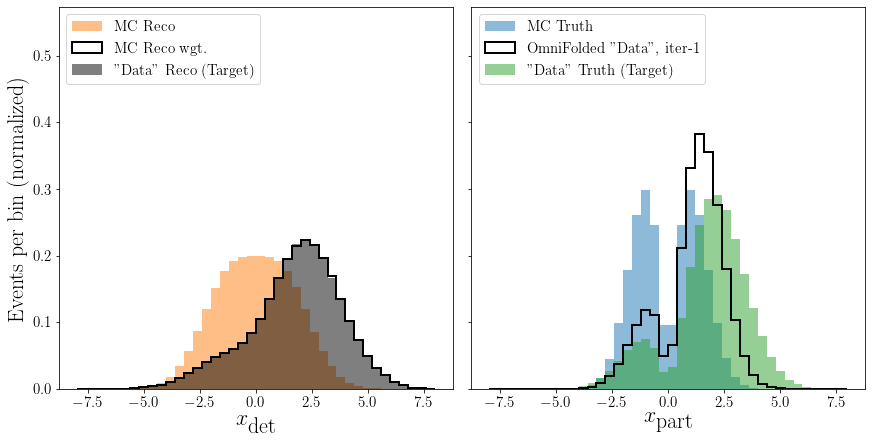

ITERATION 2:


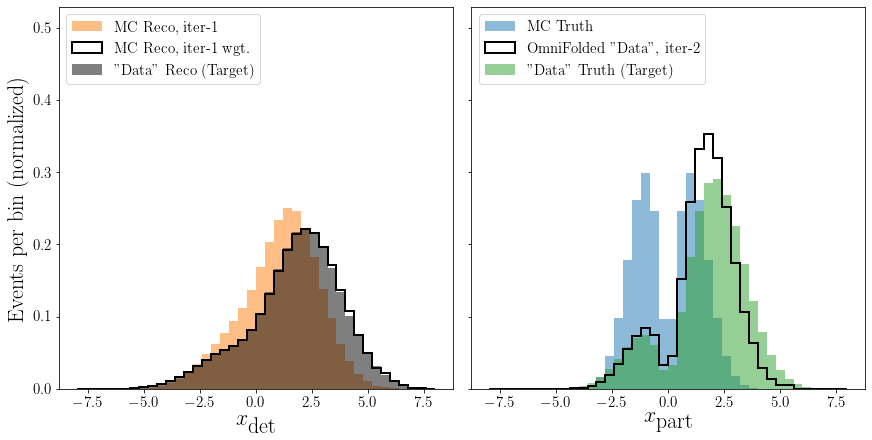

ITERATION 3:


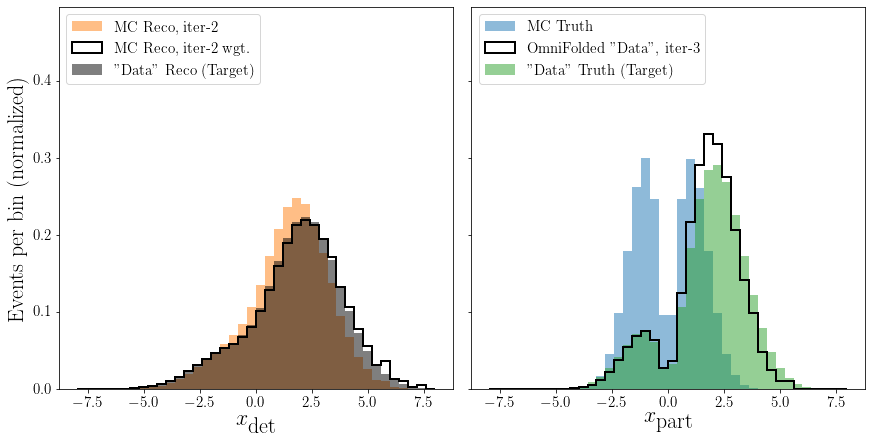

ITERATION 4:


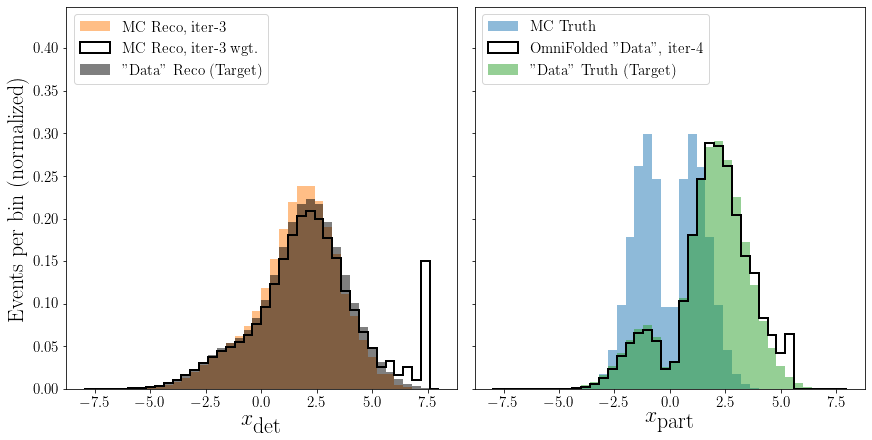

ITERATION 5:


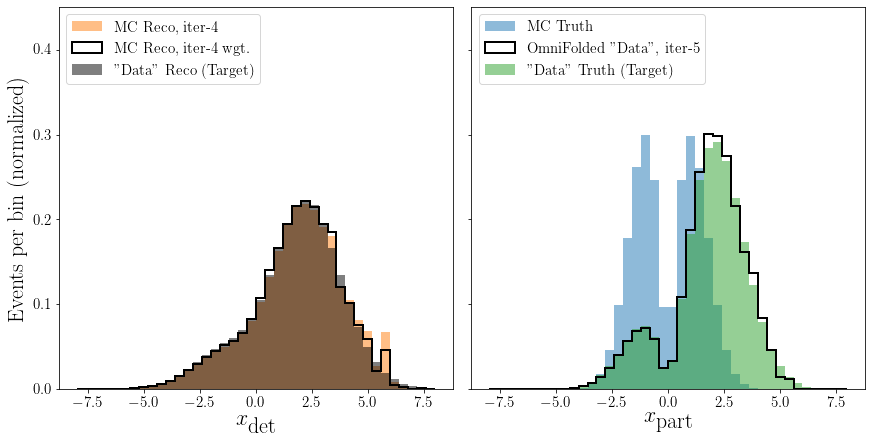

ITERATION 6:


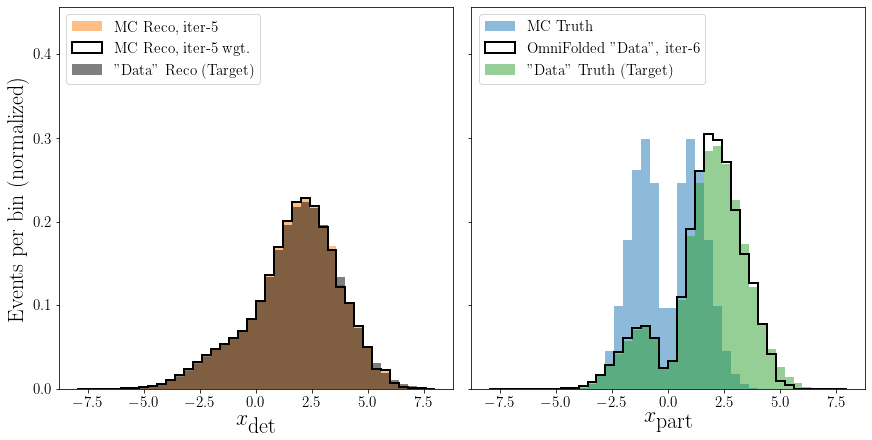

ITERATION 7:


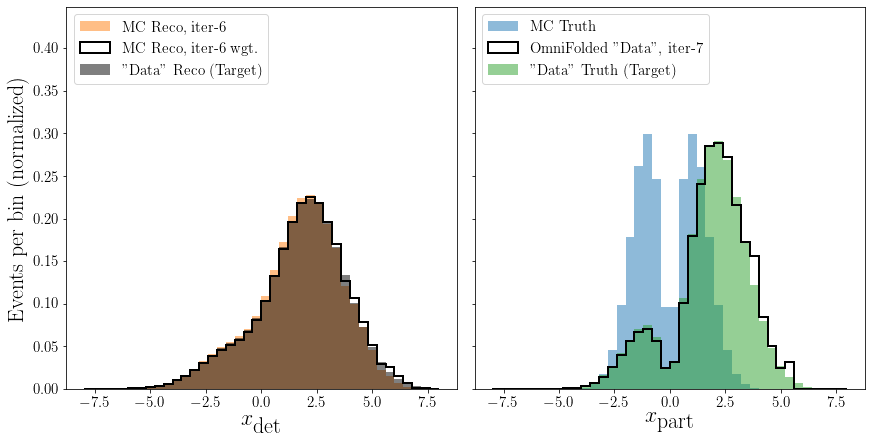

ITERATION 8:


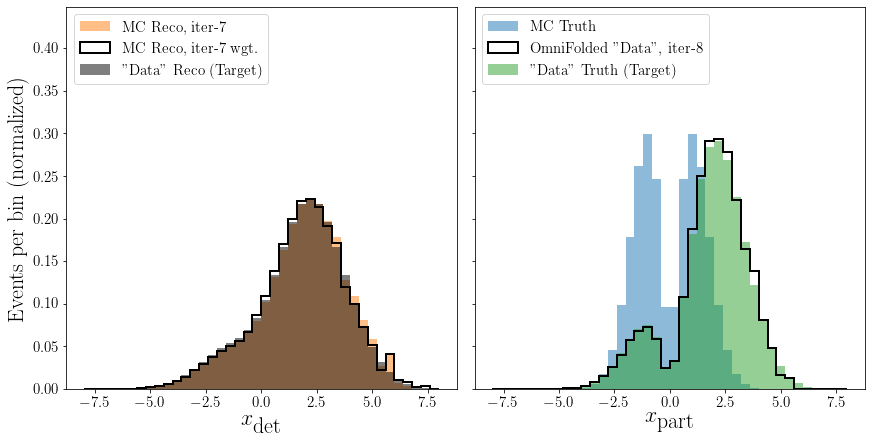

ITERATION 9:


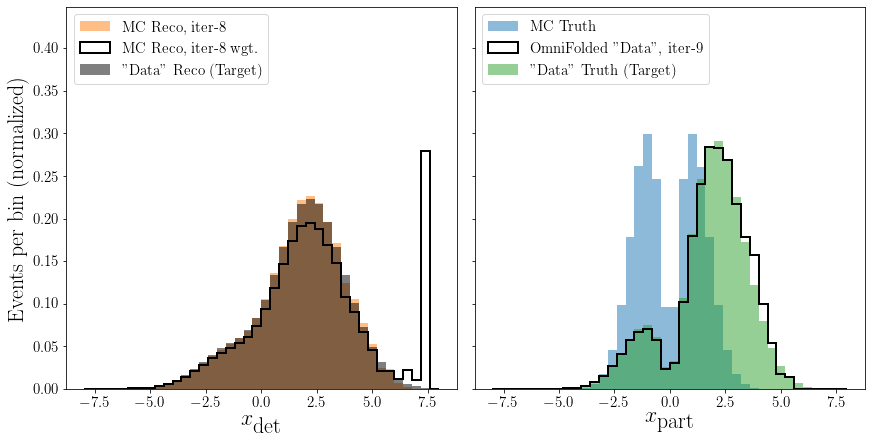

ITERATION 10:


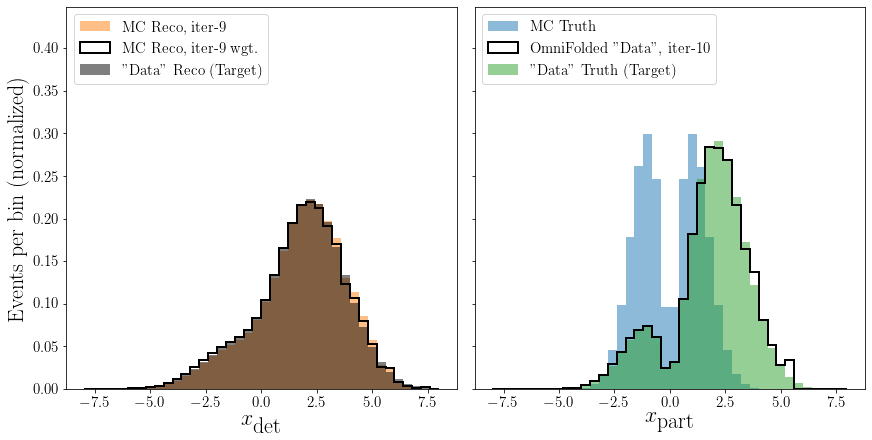

In [20]:
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))

    fig, ax = plt.subplots(1,
                           2,
                           figsize=(12, 6),
                           constrained_layout=True,
                           sharey=True)

    if i == 0:
        weights_init = weight_MC_sim
        label0 = ''.format(i)
        label1 = ', iter-{}'.format(i + 1)
    else:
        weights_init = weights[i - 1, 1, :]
        label0 = ', iter-{}'.format(i)
        label1 = ', iter-{}'.format(i + 1)

    hT0,_,_ = ax[0].hist(sim_reco,
               weights=weights_init,
               bins=bins,
               label='MC Reco'+label0,
               **plot_style_2,
               color='C1')

    hT1,_,_ = ax[0].hist(
        sim_reco,
        bins=bins,
        label='MC Reco'+label0+' wgt.',
        weights=weights[i, 0, :],
        **plot_style_1)
    hT2,_,_ = ax[0].hist(data_reco,
               weights=weights_MC_data,
               bins=bins,
               label='"Data" Reco (Target)',
               **plot_style_2,
               color='k')
    ax[0].set_xlabel(r"$x_{\textnormal{det}}$")
    ax[0].set_ylabel("Events per bin (normalized)")
    ax[0].legend(loc='upper left')
    hR0,_,_ = ax[1].hist(sim_truth,
               weights=weight_MC_sim,
               bins=bins,
               label=r'MC Truth',
               **plot_style_2)

    hR1,_,_ = ax[1].hist(
        sim_truth,
        bins=bins,
        label='OmniFolded "Data"'+label1,
        weights=weights[i, 1, :],
        **plot_style_1)
    hR2,_,_ = ax[1].hist(data_truth,
               weights=weights_MC_data,
               bins=bins,
               label='"Data" Truth (Target)',
               **plot_style_2,
               color='C2')
    ax[1].legend(loc='upper left')
    ax[1].set_xlabel(r"$x_{\textnormal{part}}$")
    
    ax[0].set_ylim([0,1.5*np.max(np.concatenate((hT0, hT1, hT2, hR0, hR1,hR2)))])

    fig.show()
    fig.savefig(
        'SupportNote/figures/GaussianToyExample/GaussianToyExample-MCUnfoldingResultsIteration{:02}.pdf'
        .format(i + 1),
        bbox_inches='tight')
    plt.show()